In [55]:
# !pip install plotly
# !pip install seaborn
# !pip install matplotlib
# !pip install transformers
# !pip install tokenizers
# !pip install scikit-learn
# !pip install tensorflow
# !pip install pandas
# !pip install numpy
# !pip install keras_tuner



In [56]:
# from google.colab import drive
# drive.mount('/content/drive')

#
<a id="data-prep"></a>
<div style="background-color: #000D5B; color: white; text-align: center; padding: 6px 0 22px 0">
    <h3 style="background-color: #000D5B; color: white; text-align: left">RMIT School of Computer Science and Technology</h3>
    <br/>
    <h1>COSC3007: Deep Learning</h1>
    <h2>Assignment 2: Stance Twitter Sentiment Analysis and Detection </h2>
    <h2> [2] MODELLING AND MODEL EVALUATIONS </h2>

</div>

# Import Libs

In [57]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import numpy as np

# [1] Load Data

In [58]:
train_df = pd.read_csv("StanceDataset/processed_train_balanced.csv", encoding = "ISO-8859-1", engine="python").drop(columns=['Unnamed: 0'])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.dropna(subset=['processed_tweet'])
train_ori = train_df.copy()

test_df = pd.read_csv("StanceDataset/processed_test_balanced.csv", encoding = "ISO-8859-1", engine="python").drop(columns=['Unnamed: 0'])
# Remove rows where the 'target' column is 5
# test_df = test_df[test_df['Target'] != 5]

# [2] Prepare label and fit data

## Split test and val

In [59]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

## Tweets

In [60]:
# Load GloVe embeddings
embedding_dim = 100  # This should match the GloVe
glove_dir = 'path_to_glove'
from tqdm import tqdm

embeddings_index = {}
with open("./glove.twitter.27B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [61]:

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_ori['processed_tweet'])

# Convert texts to sequences for all datasets
train_sequences = tokenizer.texts_to_sequences(train_df['processed_tweet'])
test_sequences = tokenizer.texts_to_sequences(test_df['processed_tweet'])
val_sequences = tokenizer.texts_to_sequences(val_df['processed_tweet'])

MAX_LENGTH = max(
    max(len(seq) for seq in train_sequences),
    max(len(seq) for seq in val_sequences),
    max(len(seq) for seq in test_sequences)
)

# Pad the sequences
train_pad = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding='post')
test_pad = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding='post')
val_pad = pad_sequences(val_sequences, maxlen=MAX_LENGTH, padding='post')

# Extract the word index and vocab size
word_index = tokenizer.word_index
print("Unique tokens: " + str(len(word_index)))
vocab_size = len(word_index) + 1
print('Vocab size: ' + str(vocab_size))
print('Max Pad Length ' + str(MAX_LENGTH))

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Unique tokens: 8007
Vocab size: 8008
Max Pad Length 33


In [62]:
print(len(train_pad))
print(len(val_df))
print(len(test_pad))

3030
758
1956


## Stances

In [63]:
def categorized_label(df, label_name):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(df[label_name])
    categorical_labels = to_categorical(encoded_labels)
    return categorical_labels

In [64]:
train_labels = categorized_label(train_df, "Stance")
test_labels = categorized_label(test_df, "Stance")
val_labels = categorized_label(val_df, "Stance")

# [3] Create Model

In [65]:
from keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import keras_tuner as kt

def f1_score_class(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def f1_score(y_true, y_pred):
    # Convert predictions to one-hot format
    y_pred_one_hot = K.one_hot(K.argmax(y_pred), num_classes=3)

    # Calculate F1 score for each class
    f1s = [f1_score_class(y_true[:, i], y_pred_one_hot[:, i]) for i in range(3)]

    # Average F1 scores across all classes
    return K.mean(K.stack(f1s), axis=0)

Set up call backs and learning rates

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

# Define the ModelCheckpoint callback
checkpoint_path = "stance_best_model_tuned_weights_balanced.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # Only save a model if 'val_loss' has improved
    monitor='val_loss',     # Monitor 'val_loss' during training
    mode='min',             # The model is saved when 'val_loss' is minimized
    verbose=1)

# Combine all callbacks in a list
callbacks = [
    early_stopping,
    lr_scheduler,
    model_checkpoint_callback
]


# Combine all callbacks in a list
callbacks1 = [
    early_stopping,
    # lr_scheduler,
    model_checkpoint_callback
]

Set up keras tuner

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import classification_report
import numpy as np
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

    # Tuning the number of units in the first biLSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   dropout=hp.Float('dropout1', min_value=0, max_value=0.8, step=0.1),
                   recurrent_dropout=hp.Float('recurrent_dropout1', min_value=0, max_value=0.5, step=0.1),
                   kernel_regularizer=l2(hp.Float('l2_reg1', min_value=0.0001, max_value=0.01, sampling='LOG')))))

    model.add(Flatten())

    # Dense layer with tunable units
    model.add(Dense(
        units=hp.Int('dense_layer_units_1', min_value=32, max_value=512, step=32),
        activation="relu",
        kernel_regularizer=l2(hp.Float('dense_l2_reg', min_value=0.0001, max_value=0.005, sampling='LOG'))
    ))

    # Tunable dropout rate for the second layer
    dropout_rate_3 = hp.Float('dropout__layer_3', min_value=0.0, max_value=0.8, step=0.1)
    model.add(Dropout(dropout_rate_3))

    # Final Layer
    model.add(Dense(3, activation='softmax'))

    # Tuning the learning rate for the optimizer
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', f1_score])

    return model


In [68]:
stop

NameError: name 'stop' is not defined

KERAS TUNER WILL FIND THE BEST HPS then further tune the model with the best hps

In [ ]:
best_model = None
best_hps = None

# Hyperparameter tuning configuration
objective = kt.Objective("val_f1_score", direction="max")
tuning_config = {
    'objective': objective,
    'max_epochs': 30,
    'directory': 'keras_tuner_dir',
    'project_name': 'lstm_stance_classification_balanced'
}

# Early stopping callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

batch_size = 32

# for batch_size in batch_sizes:
print(f"Trying batch size: {batch_size}")

# Initialize the tuner
tuner = kt.Hyperband(build_model, **tuning_config)

# Search for the best hyperparameters
tuner.search(train_pad, train_labels,
            epochs=50,
            validation_data=(val_pad, val_labels),
            callbacks=[stop_early],
            batch_size=batch_size)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model.save('stance_best_model_model_balanced.h5')
best_model.save_weights("stance_best_model_weights_balanced.h5")

Trial 90 Complete [00h 07m 32s]
val_f1_score: 0.5390790104866028

Best val_f1_score So Far: 0.5714267492294312
Total elapsed time: 01h 44m 41s


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate best keras tuner model

In [ ]:
results = best_model.evaluate(test_pad, test_labels)
print('Test accuracy:', results)

62/62 [==============================] - 2s 22ms/step - loss: 1.1217 - categorical_accuracy: 0.5112 - f1_score: 0.3721
Test accuracy: [1.121686339378357, 0.511247456073761, 0.37207382917404175]


In [ ]:
# Get model predictions
predictions = best_model.predict(test_pad)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, convert them to class labels
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

62/62 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      1014
           1       0.41      0.39      0.40       452
           2       0.39      0.42      0.40       490

    accuracy                           0.51      1956
   macro avg       0.47      0.47      0.47      1956
weighted avg       0.51      0.51      0.51      1956



In [ ]:
with open('./glove_lstm_best_hyperparameters_balanced.txt', 'w') as f:
    for hparam in best_hps.values:
        f.write(f"{hparam}: {best_hps.get(hparam)}\n")

Recreate the best model with more training time

In [ ]:
def load_hyperparameters(file_path):
    hyperparameters = {}
    with open(file_path, 'r') as file:
        for line in file:
            key, value = line.strip().split(': ')
            # Convert value to the appropriate type
            if value.isdigit():
                value = int(value)  # Convert to integer if possible
            elif value.replace('.', '', 1).isdigit() and '.' in value:
                value = float(value)  # Convert to float if possible
            hyperparameters[key] = value
    return hyperparameters

# Load the hyperparameters
file_path = './glove_lstm_best_hyperparameters_balanced.txt'  # Replace with your file path
best_hps = load_hyperparameters(file_path)

In [ ]:
best_hps

{'units1': 32,
 'dropout1': 0.7000000000000001,
 'recurrent_dropout1': 0.30000000000000004,
 'l2_reg1': 0.00020902709378457082,
 'dense_layer_units_1': 352,
 'dense_l2_reg': 0.00039925647645921823,
 'dropout__layer_3': 0.2,
 'learning_rate': 0.0016767367974422334,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': 79}

In [ ]:
def build_model_from_dict(hp_dict):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

    # Use the hyperparameter values from the dictionary
    model.add(Bidirectional(LSTM(units=hp_dict['units1'],
                   return_sequences=True,
                   dropout=hp_dict['dropout1'],
                   recurrent_dropout=hp_dict['recurrent_dropout1'],
                   kernel_regularizer=l2(hp_dict['l2_reg1']))))

    model.add(Flatten())

    # Dense layer with tunable units
    model.add(Dense(
        units=hp_dict['dense_layer_units_1'],
        activation="relu",
        kernel_regularizer=l2(hp_dict['dense_l2_reg'])
    ))

    # Tunable dropout rate for the second layer
    dropout_rate_3 = hp_dict['dropout__layer_3']
    model.add(Dropout(dropout_rate_3))

    # Final Layer
    model.add(Dense(3, activation='softmax'))

    # Tuning the learning rate for the optimizer
    model.compile(optimizer=Adam(hp_dict['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', f1_score])

    return model

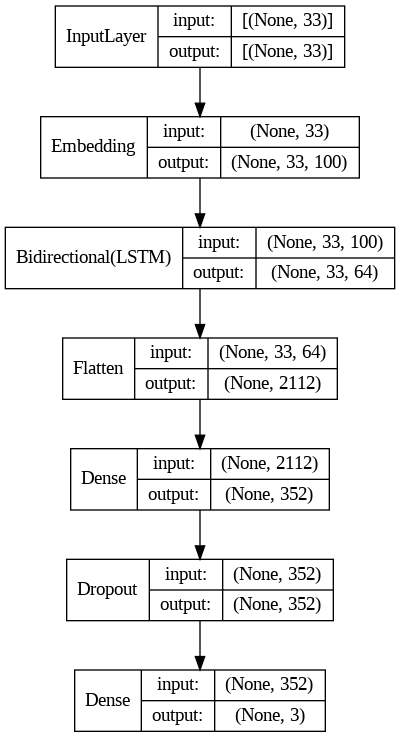

In [ ]:
from tensorflow.keras.utils import plot_model
model = build_model_from_dict(best_hps)
plot_model(model, show_layer_names=False, show_shapes=True, to_file='tuned_stance_model_balanced.png')

In [ ]:
history = {}
history['tuned_stance_model'] = model.fit(train_pad, train_labels,
                    epochs=100,
                    validation_data=(val_pad, val_labels),
                    batch_size=32,
                    callbacks=callbacks1,
                    shuffle = True)

Epoch 1/100
95/95 [==============================] - ETA: 0s - loss: 1.2813 - categorical_accuracy: 0.4373 - f1_score: 0.3035
Epoch 1: saving model to stance_best_model_tuned_weights_balanced.h5
95/95 [==============================] - 20s 157ms/step - loss: 1.2813 - categorical_accuracy: 0.4373 - f1_score: 0.3035 - val_loss: 1.1881 - val_categorical_accuracy: 0.4921 - val_f1_score: 0.3569
Epoch 2/100
95/95 [==============================] - ETA: 0s - loss: 1.1583 - categorical_accuracy: 0.4937 - f1_score: 0.4001
Epoch 2: saving model to stance_best_model_tuned_weights_balanced.h5
95/95 [==============================] - 14s 144ms/step - loss: 1.1583 - categorical_accuracy: 0.4937 - f1_score: 0.4001 - val_loss: 1.1217 - val_categorical_accuracy: 0.5422 - val_f1_score: 0.4674
Epoch 3/100
95/95 [==============================] - ETA: 0s - loss: 1.1188 - categorical_accuracy: 0.5178 - f1_score: 0.4409
Epoch 3: saving model to stance_best_model_tuned_weights_balanced.h5
95/95 [============

In [ ]:
results = model.evaluate(test_pad, test_labels)
print('Test accuracy:', results)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Get model predictions
predictions = model.predict(test_pad)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, convert them to class labels
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

In [ ]:
results = model.evaluate(val_pad, val_labels)
print('Test accuracy:', results)

In [ ]:
model.save('stance_best_model_model_extra_balanced.h5')
model.save_weights("stance_best_model_weights_extra_balanced.h5")

# [4] Evaluation

In [69]:
from tensorflow.keras.models import load_model

model_path = './Keras_tuner_items_balanced/stance_best_model_model_balanced.h5'  # Replace with your model's file path
best_model = load_model(model_path, custom_objects={'f1_score': f1_score})

from sklearn.metrics import classification_report
import numpy as np
# Get model predictions
predictions = best_model.predict(test_pad)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Assuming test_labels are one-hot encoded, convert them to class labels
true_labels = np.argmax(test_labels, axis=1)

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print(report)

2024-01-01 10:51:42.181739: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-01-01 10:51:42.181768: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-01 10:51:42.181782: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-01 10:51:42.181848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-01 10:51:42.181881: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-01-01 10:51:42.819934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 13s 200ms/step
              precision    recall  f1-score   support

           0       0.64      0.47      0.54      1014
           1       0.32      0.51      0.39       452
           2       0.37      0.37      0.37       490

    accuracy                           0.46      1956
   macro avg       0.44      0.45      0.44      1956
weighted avg       0.50      0.46      0.46      1956



In [70]:
def load_classification_rp_per_target(model):
    targets = test_df.Target.unique()
    metrics_df = pd.DataFrame()
    for target in targets:
        extracted_df = test_df[test_df['Target'] == target]
        sequences = tokenizer.texts_to_sequences(extracted_df['processed_tweet'])
        pad = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')
        # Assuming categorized_label returns a one-hot encoded DataFrame
        # Get labels using the categorized_label function
        labels = categorized_label(extracted_df, "Stance")
        
        # Convert one-hot encoded labels to single integer class labels
        true_labels = np.argmax(labels, axis=1)

        # Get model predictions
        predictions = best_model.predict(pad)

        # Convert predictions to class labels
        predicted_labels = np.argmax(predictions, axis=1)

        # Generate a classification report
        report = classification_report(true_labels, predicted_labels, target_names=['AGAINST', 'FAVOR', 'NONE'])
        target_name = ""
        if target == 0:
            target_name = "Hillary Clinton"
        if target == 1:
            target_name = "Legalization of Abortion"
        if target == 2:
            target_name = "Atheism"
        if target == 3:
            target_name = "Climate Change is a Real Concern"
        if target == 4:
            target_name = "Feminist Movement"
        if target == 5:
            target_name = "Donald Trump"

        print('Target: ', target_name)
        print(report)
        print("-----------------------------------------", "\n")

        # Flatten the report into a single row and add target name
        report = classification_report(true_labels, predicted_labels, target_names=['AGAINST', 'FAVOR', 'NONE'], output_dict=True)

        # Extract weighted f1, macro f1, and accuracy
        report_data = {
            'Target': target_name,
            'Weighted F1': report['weighted avg']['f1-score'],
            'Macro F1': report['macro avg']['f1-score'],
            'Accuracy': report['accuracy']
        }

        # Append to the DataFrame
        metrics_df = metrics_df.append(report_data, ignore_index=True)
    metrics_df.set_index('Target', inplace=True)
 
    return metrics_df

In [71]:
# Use the function to get the metrics DataFrame
model_metrics_df = load_classification_rp_per_target(best_model)
model_metrics_df

7/7 [==============================] - 1s 211ms/step
Target:  Atheism
              precision    recall  f1-score   support

     AGAINST       0.82      0.68      0.74       160
       FAVOR       0.16      0.34      0.22        32
        NONE       0.24      0.18      0.20        28

    accuracy                           0.56       220
   macro avg       0.41      0.40      0.39       220
weighted avg       0.65      0.56      0.60       220

----------------------------------------- 



/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_66004/887463637.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(report_data, ignore_index=True)


6/6 [==============================] - 2s 290ms/step
Target:  Climate Change is a Real Concern
              precision    recall  f1-score   support

     AGAINST       0.17      0.09      0.12        11
       FAVOR       0.81      0.89      0.85       123
        NONE       0.50      0.40      0.44        35

    accuracy                           0.74       169
   macro avg       0.49      0.46      0.47       169
weighted avg       0.71      0.74      0.72       169

----------------------------------------- 



/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_66004/887463637.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(report_data, ignore_index=True)


9/9 [==============================] - 2s 229ms/step
Target:  Feminist Movement
              precision    recall  f1-score   support

     AGAINST       0.73      0.46      0.57       183
       FAVOR       0.25      0.53      0.34        58
        NONE       0.52      0.50      0.51        44

    accuracy                           0.48       285
   macro avg       0.50      0.50      0.47       285
weighted avg       0.60      0.48      0.51       285

----------------------------------------- 



/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_66004/887463637.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(report_data, ignore_index=True)


10/10 [==============================] - 2s 234ms/step
Target:  Hillary Clinton
              precision    recall  f1-score   support

     AGAINST       0.70      0.64      0.67       172
       FAVOR       0.21      0.22      0.22        45
        NONE       0.37      0.42      0.39        78

    accuracy                           0.52       295
   macro avg       0.43      0.43      0.43       295
weighted avg       0.54      0.52      0.53       295

----------------------------------------- 



/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_66004/887463637.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(report_data, ignore_index=True)


9/9 [==============================] - 2s 210ms/step
Target:  Legalization of Abortion
              precision    recall  f1-score   support

     AGAINST       0.73      0.51      0.60       189
       FAVOR       0.24      0.57      0.33        46
        NONE       0.34      0.29      0.31        45

    accuracy                           0.49       280
   macro avg       0.44      0.46      0.42       280
weighted avg       0.59      0.49      0.51       280

----------------------------------------- 



/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_66004/887463637.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(report_data, ignore_index=True)


23/23 [==============================] - 5s 228ms/step
Target:  Donald Trump
              precision    recall  f1-score   support

     AGAINST       0.37      0.26      0.31       299
       FAVOR       0.19      0.28      0.22       148
        NONE       0.35      0.36      0.35       260

    accuracy                           0.30       707
   macro avg       0.30      0.30      0.30       707
weighted avg       0.32      0.30      0.31       707

----------------------------------------- 



/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_66004/887463637.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(report_data, ignore_index=True)


,Weighted F1,Macro F1,Accuracy
Target,,,
Atheism,0.596280,0.388677,0.563636
Climate Change is a Real Concern,0.720316,0.471602,0.739645
Feminist Movement,0.511421,0.471750,0.484211
Hillary Clinton,0.526561,0.425535,0.518644
Legalization of Abortion,0.513050,0.416983,0.485714
Donald Trump,0.306964,0.295045,0.302687
